In [ ]:
%pip install -q git+https://github.com/yfukai/BaSiCPy@autosegment
%pip install -q plotly==5.4.0

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.1/64.1 kB 781.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 17.8 MB/s eta 0:00:00


In [ ]:
import xarray

print(xarray.__version__)
import numpy as np
from os import path
import os

# from aicsimageio import AICSImage
# from aicspylibczi import CziFile
from tqdm import tqdm
from itertools import product
from matplotlib import pyplot as plt
from skimage.io import imread, imread_collection, imsave
from skimage.io import imshow_collection
import pandas as pd
from skimage.transform import resize
from skimage import filters
from skimage.morphology import binary_dilation, binary_erosion, disk, square

# from cucim.skimage.morphology import binary_erosion, disk

from skimage.filters import threshold_multiotsu
from basicpy import BaSiC
from basicpy.metrics import autotune_cost, entropy, fourier_L0_norm

2023.7.0


In [ ]:
import glob

# file_path = "/content/drive/MyDrive/Colab Notebooks/BaSiCPy-dev/Simulation/simulatedimages/"
file_path = (
    "/content/drive/MyDrive/Colab Notebooks/BaSiCPy/Simulated_data/simulatedimages/"
)

nuc_channel_idx = 2
cyto_channel_idx = 0

In [ ]:
flatfield_true = np.load(path.join(file_path, f"flatfield_true.npy"))

In [ ]:
weights = imread(path.join(file_path, "weights.tif"))

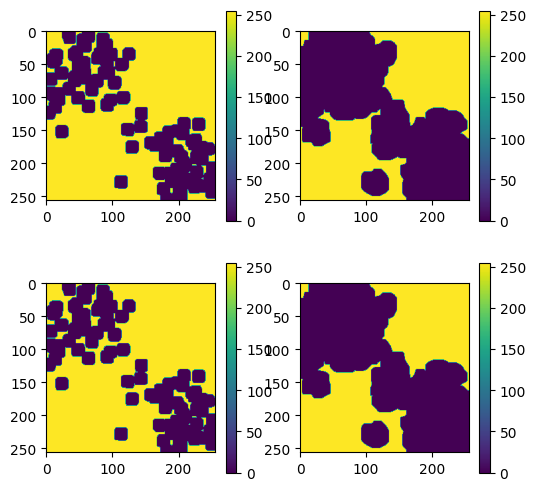

In [ ]:
plt.figure(figsize=(6, 6))
plt.subplot(221)
plt.imshow(weights[nuc_channel_idx, 100])
plt.colorbar()
plt.subplot(222)
plt.imshow(weights[cyto_channel_idx, 100])
plt.colorbar()
plt.subplot(223)
plt.imshow(weights[nuc_channel_idx, 100])
plt.colorbar()
plt.subplot(224)
plt.imshow(weights[cyto_channel_idx, 100])
plt.colorbar()

In [ ]:
darkfield_true = np.load(path.join(file_path, f"darkfield_true.npy"))
baseline_true = np.load(path.join(file_path, f"baseline_true.npy"))

In [ ]:
images_distorted_wo_darkfield = imread(path.join(file_path, "wo_darkfield2.tif"))
images_distorted_w_darkfield = imread(path.join(file_path, "w_darkfield2.tif"))

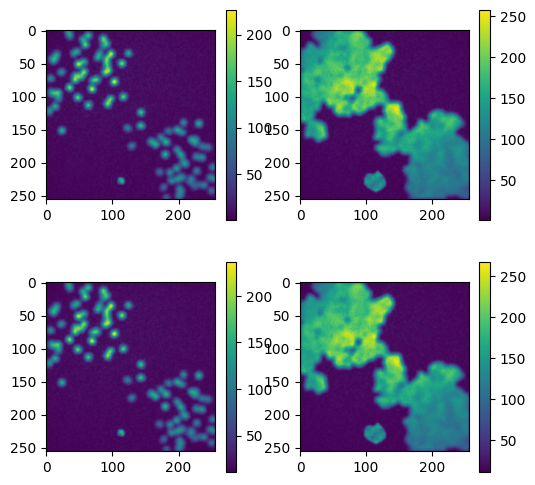

In [ ]:
plt.figure(figsize=(6, 6))
plt.subplot(221)
plt.imshow(images_distorted_wo_darkfield[nuc_channel_idx, 100])
plt.colorbar()
plt.subplot(222)
plt.imshow(images_distorted_wo_darkfield[cyto_channel_idx, 100])
plt.colorbar()
plt.subplot(223)
plt.imshow(images_distorted_w_darkfield[nuc_channel_idx, 100])
plt.colorbar()
plt.subplot(224)
plt.imshow(images_distorted_w_darkfield[cyto_channel_idx, 100])
plt.colorbar()

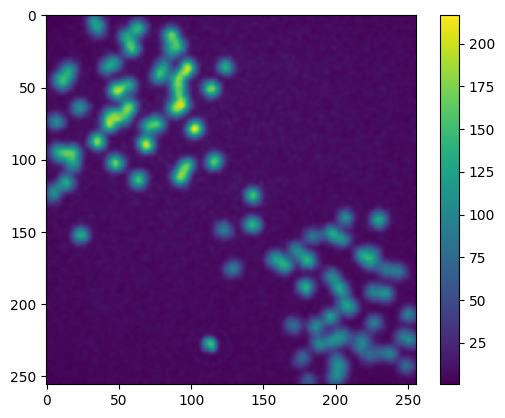

In [ ]:
plt.imshow(add_noise(images_distorted_wo_darkfield[nuc_channel_idx, 100]))
plt.colorbar()

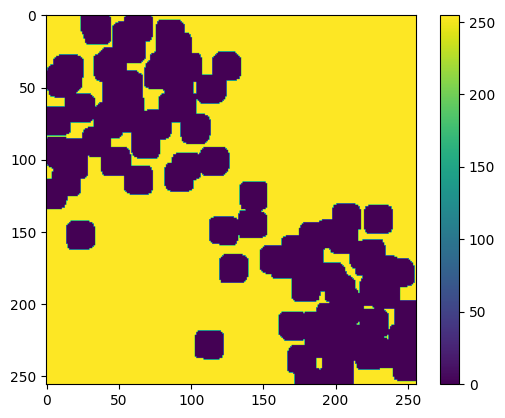

In [ ]:
plt.imshow(weights[nuc_channel_idx, 100])
plt.colorbar()

In [ ]:
histogram_qmin: float = 0.01
histogram_qmax: float = 0.99
vmin_factor: float = 0.6
vrange_factor: float = 1.5
histogram_bins: int = 1000
histogram_use_fitting_weight: bool = True
fourier_l0_norm_image_threshold: float = 0.1
fourier_l0_norm_fourier_radius = 10
fourier_l0_norm_threshold = 1e-3
fourier_l0_norm_cost_coef = 1e4

In [ ]:
conds0 = list(
    product(
        ["ladmap", "approximate"],  # fitting_mode
        [False],
        [True, False],
    )
)
conds = list(
    product(
        list(np.logspace(-3, 2, 15)),
        ["ladmap", "approximate"],  # fitting_mode
        [False],
        [True, False],
        list(range(5)),
    )
)
parameters = []
for channel_index in [nuc_channel_idx, cyto_channel_idx][:]:
    for fitting_mode, sort_intensity, use_weight in tqdm(conds0):
        np.random.seed(1135 + channel_index * 50000)
        p = {
            "smoothness_flatfield": 0.1,
            "fitting_mode": fitting_mode,
            "sort_intensity": sort_intensity,
        }
        p2 = p.copy()
        p2.update(
            {
                "channel_index": channel_index,
                "use_weight": use_weight,
            }
        )
        b = BaSiC(**p, get_darkfield=False)
        im = images_distorted_wo_darkfield[channel_index]
        im = add_noise(im)
        w = weights[channel_index] if use_weight else None

        b.fit(im, fitting_weight=w)
        transformed_image = b.transform(im, timelapse=True)
        vmin, vmax = np.quantile(transformed_image, [histogram_qmin, histogram_qmax])
        entropy_vmin = vmin_factor * vmin
        val_range = (vmax - vmin * vmin_factor) * vrange_factor
        p2["val_range"] = val_range
        parameters.append(p2)

val_ranges_df = pd.DataFrame.from_records(parameters).set_index(
    ["channel_index", "fitting_mode", "sort_intensity", "use_weight"]
)
val_ranges_df.to_csv(
    path.join(file_path, f"wo_darkfield_val_ranges_channel_{channel_index}.csv")
)

100%|██████████| 4/4 [00:20<00:00,  5.03s/it]


In [ ]:
for channel_index in [nuc_channel_idx, cyto_channel_idx][:]:
    parameters = []
    flatfields = []
    baselines = []
    for smoothness_flatfield, fitting_mode, sort_intensity, use_weight, rep in tqdm(
        conds
    ):
        val_range = val_ranges_df.loc[
            (channel_index, fitting_mode, sort_intensity, use_weight), "val_range"
        ]
        np.random.seed(1135 + channel_index * 50000 + rep)
        p = {
            "smoothness_flatfield": smoothness_flatfield,
            "fitting_mode": fitting_mode,
            "sort_intensity": sort_intensity,
        }
        p2 = p.copy()
        p2.update(
            {"channel_index": channel_index, "use_weight": use_weight, "rep": rep}
        )
        b = BaSiC(**p, get_darkfield=False)
        im = images_distorted_wo_darkfield[channel_index]
        im = add_noise(im)
        w = weights[channel_index] if use_weight else None

        try:
            b.fit(im, fitting_weight=w)
            flatfields.append(b.flatfield)
            baselines.append(b.baseline)

            transformed_image = b.transform(im, timelapse=True)
            vmin, vmax = np.quantile(
                transformed_image, [histogram_qmin, histogram_qmax]
            )
            entropy_vmin = vmin_factor * vmin
            entropy_vmax = entropy_vmin + val_range
            p2["entropy"] = entropy(
                transformed_image,
                vmin=entropy_vmin,
                vmax=entropy_vmax,
                bins=histogram_bins,
                weights=w,
                clip=True,
            )
            p2["fourier_L0_norm"] = fourier_L0_norm(
                b.flatfield,
                fourier_l0_norm_image_threshold,
                fourier_l0_norm_fourier_radius,
            )
            p2["autotune_cost"] = autotune_cost(
                transformed_image,
                b.flatfield,
                entropy_vmin=entropy_vmin,
                entropy_vmax=entropy_vmax,
                histogram_bins=histogram_bins,
                fourier_l0_norm_cost_coef=fourier_l0_norm_cost_coef,
                fourier_l0_norm_image_threshold=fourier_l0_norm_image_threshold,
                fourier_l0_norm_fourier_radius=fourier_l0_norm_fourier_radius,
                fourier_l0_norm_threshold=fourier_l0_norm_threshold,
            )
        except RuntimeError:
            flatfields.append(np.ones_like(b.flatfield) * np.nan)
            baselines.append(np.ones_like(b.baseline) * np.nan)
            p2["autotune_cost"] = np.nan
        finally:
            parameters.append(p2)

    np.save(
        path.join(file_path, f"wo_darkfield_flatfields_channel_{channel_index}_2.npy"),
        flatfields,
    )
    np.save(
        path.join(file_path, f"wo_darkfield_baselines_channel_{channel_index}_2.npy"),
        baselines,
    )
    assert len(flatfields) == len(parameters)
    parameters_df = pd.DataFrame.from_records(parameters)
    parameters_df.to_csv(
        path.join(file_path, f"wo_darkfield_parameters_channel_{channel_index}_2.csv")
    )

100%|██████████| 300/300 [29:45<00:00,  5.95s/it]
/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)
100%|██████████| 300/300 [29:54<00:00,  5.98s/it]
/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [ ]:
parameters_df

,smoothness_flatfield,fitting_mode,sort_intensity,channel_index,use_weight,rep,autotune_cost
0,0.001,ladmap,False,0,True,0,3999.881368
1,0.001,ladmap,False,0,True,1,3973.925340
2,0.001,ladmap,False,0,False,0,3449.012803
3,0.001,ladmap,False,0,False,1,3456.958090
4,0.001,approximate,False,0,True,0,3046.619839
5,0.001,approximate,False,0,True,1,3034.854246
6,0.001,approximate,False,0,False,0,3644.661496
7,0.001,approximate,False,0,False,1,3646.647415


In [ ]:
conds0 = list(
    product(
        ["ladmap", "approximate"],  # fitting_mode
        [
            # True,
            False
        ],
        [True, False],
    )
)

conds = list(
    product(
        [
            nuc_channel_idx,
            cyto_channel_idx,
        ],
        list(np.logspace(-3, 2, 4)),
        list(np.logspace(-3, 2, 4)),
        list(np.logspace(-3, 2, 4)),
        list(range(5)),
    )
)
np.random.seed(1136)
for fitting_mode, sort_intensity, use_weight in conds0:
    parameters_d = []
    flatfields_d = []
    darkfields_d = []
    baselines_d = []
    label = f"{fitting_mode}_sort{sort_intensity}_weight{use_weight}"
    for (
        channel_index,
        smoothness_flatfield,
        smoothness_darkfield,
        sparse_cost_darkfield,
        rep,
    ) in tqdm(conds):
        p = {
            "smoothness_flatfield": smoothness_flatfield,
            "smoothness_darkfield": smoothness_darkfield,
            "sparse_cost_darkfield": sparse_cost_darkfield,
            "fitting_mode": fitting_mode,
            "sort_intensity": sort_intensity,
        }
        p2 = p.copy()
        p2.update(
            {"channel_index": channel_index, "use_weight": use_weight, "rep": rep}
        )
        parameters_d.append(p2)
        im = images_distorted_w_darkfield[channel_index]
        im = add_noise(im)
        b = BaSiC(**p, get_darkfield=True)
        try:
            b.fit(im, fitting_weight=weights[channel_index] if use_weight else None)
            flatfields_d.append(b.flatfield)
            darkfields_d.append(b.darkfield)
            baselines_d.append(b.baseline)
        except RuntimeError:
            flatfields_d.append(np.ones_like(b.flatfield) * np.nan)
            darkfields_d.append(np.ones_like(b.darkfield) * np.nan)
            baselines_d.append(np.ones_like(b.baseline) * np.nan)

    np.save(path.join(file_path, f"w_darkfield_flatfields_{label}.npy"), flatfields_d)
    np.save(path.join(file_path, f"w_darkfield_darkfields_{label}.npy"), darkfields_d)
    np.save(path.join(file_path, f"w_darkfield_baselines_{label}.npy"), baselines_d)
    parameters_df = pd.DataFrame.from_records(parameters_d)
    parameters_df.to_csv(path.join(file_path, f"w_darkfield_parameters_{label}.csv"))

  3%|▎         | 19/640 [38:44<21:06:28, 122.36s/it]


KeyboardInterrupt: ignored